In [1]:
!pip install pandas matplotlib seaborn

Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-01.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-01.zip ...
Extracted: binance_data/BTCUSDT/BTCUSDT-1h-2024-01.csv
Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-02.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-02.zip ...
Extracted: binance_data/BTCUSDT/BTCUSDT-1h-2024-02.csv
Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-03.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-03.zip ...
Extracted: binance_data/BTCUSDT/BTCUSDT-1h-2024-03.csv
Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-04.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-04.zip ...
Extracted: binance_data/BTCUSDT/BTCUSDT-1h-2024-04.csv
Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-05.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-05.zip ...
Extracted: binance_data/BTCUSDT/BTCUSDT-1h-2024-05.csv
Downloaded: binance_data/BTCUSDT/BTCUSDT-1h-2024-06.zip
Extracting binance_data/BTCUSDT/BTCUSDT-1h-2024-06.zip ...
Extracted: binance_data/BTCUSDT/BTC

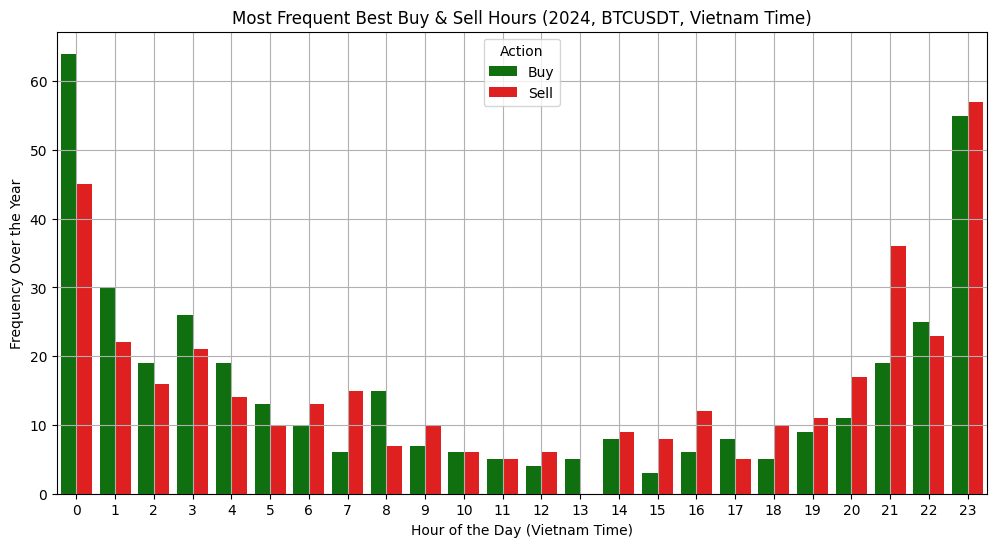

In [2]:
import requests
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytz  # For timezone conversion

# Set target timezone
vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")

# Define trading pair (symbol)
SYMBOL = "BTCUSDT"  # Change this to test other symbols (e.g., "ETHUSDT", "BNBUSDT")
TIMEFRAME = "1h"  # Timeframe (1-hour candles)
YEAR = 2024  # Year to download data for

# Directory to store extracted CSV files
output_dir = f"binance_data/{SYMBOL}"
os.makedirs(output_dir, exist_ok=True)

# Loop through each month of the selected year
all_data = []

for month in range(1, 13):
    # Format month as two digits (e.g., "01" for January)
    month_str = f"{month:02d}"
    
    # Construct the download URL dynamically based on symbol and timeframe
    url = f"https://data.binance.vision/data/futures/um/monthly/klines/{SYMBOL}/{TIMEFRAME}/{SYMBOL}-{TIMEFRAME}-{YEAR}-{month_str}.zip"
    
    # Define file paths
    zip_file = os.path.join(output_dir, f"{SYMBOL}-{TIMEFRAME}-{YEAR}-{month_str}.zip")
    csv_file = os.path.join(output_dir, f"{SYMBOL}-{TIMEFRAME}-{YEAR}-{month_str}.csv")
    
    # Step 1: Download the ZIP file
    print(f"Downloading {url} ...")
    response = requests.get(url, stream=True)
    
    if response.status_code == 200:
        with open(zip_file, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {zip_file}")
    
        # Step 2: Extract the CSV file
        print(f"Extracting {zip_file} ...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extracted: {csv_file}")

        # Step 3: Load CSV file into Pandas with correct headers
        column_names = [
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "count", "taker_buy_volume",
            "taker_buy_quote_volume", "ignore"
        ]

        df = pd.read_csv(csv_file, names=column_names, header=0)

        # Convert timestamp to datetime (UTC)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)

        # Convert to Asia/Ho_Chi_Minh timezone
        df['timestamp'] = df['timestamp'].dt.tz_convert(vietnam_tz)

        # Extract local date and hour
        df['date'] = df['timestamp'].dt.date
        df['hour'] = df['timestamp'].dt.hour

        # Step 4: Find the best buy (lowest low) and sell (highest high) hour for each day
        daily_buy_sell = df.groupby(['date', 'hour']).agg(
            min_low=('low', 'min'),
            max_high=('high', 'max')
        ).reset_index()

        # Best buy hour per day
        best_buy = daily_buy_sell.loc[daily_buy_sell.groupby('date')['min_low'].idxmin()]
        best_buy['action'] = 'Buy'

        # Best sell hour per day
        best_sell = daily_buy_sell.loc[daily_buy_sell.groupby('date')['max_high'].idxmax()]
        best_sell['action'] = 'Sell'

        # Combine both
        best_hours = pd.concat([best_buy, best_sell])

        # Append to all_data list
        all_data.append(best_hours)

        # Cleanup: Remove ZIP file
        os.remove(zip_file)
    else:
        print(f"Failed to download: {url}")

# Combine data from all months
full_year_data = pd.concat(all_data, ignore_index=True)

# Step 5: Summarize over the year (count occurrences of each hour)
hourly_summary = full_year_data.groupby(['hour', 'action']).size().reset_index(name='count')

# Save summary to CSV for review
summary_csv = os.path.join(output_dir, f"hourly_buy_sell_summary_{YEAR}_{SYMBOL}_vietnam_time.csv")
hourly_summary.to_csv(summary_csv, index=False)
print(f"Hourly summary saved to {summary_csv}")

# Step 6: Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_summary, x='hour', y='count', hue='action', palette={'Buy': 'green', 'Sell': 'red'})

plt.xlabel("Hour of the Day (Vietnam Time)")
plt.ylabel("Frequency Over the Year")
plt.title(f"Most Frequent Best Buy & Sell Hours ({YEAR}, {SYMBOL}, Vietnam Time)")
plt.xticks(range(0, 24))
plt.legend(title="Action")
plt.grid()
plt.show()

In [3]:
# Combine all OHLCV data into one DataFrame (full dataset)
all_ohlcv = []  # List to hold data from all months

for month in range(1, 13):
    month_str = f"{month:02d}"
    csv_file = os.path.join(output_dir, f"{SYMBOL}-{TIMEFRAME}-{YEAR}-{month_str}.csv")

    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file, names=column_names, header=0)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
        df['timestamp'] = df['timestamp'].dt.tz_convert(vietnam_tz)  # Convert to Vietnam time
        all_ohlcv.append(df)

# Merge all months into a single DataFrame
if all_ohlcv:
    full_year_ohlcv = pd.concat(all_ohlcv, ignore_index=True)
    print("✅ Successfully merged OHLCV data for all months!")
else:
    print("⚠️ No OHLCV data available. Please check downloads.")
    full_year_ohlcv = pd.DataFrame(columns=column_names)

# Extract useful columns
full_year_ohlcv['date_hour'] = full_year_ohlcv['timestamp'].dt.strftime('%Y-%m-%d %H:00')
full_year_ohlcv['date'] = full_year_ohlcv['timestamp'].dt.date
full_year_ohlcv['hour'] = full_year_ohlcv['timestamp'].dt.hour

✅ Successfully merged OHLCV data for all months!



🔍 Best Hour for Buying BTC (Whole Year): 0:00 Vietnam Time

Running backtest for buying $100 BTC every day at the best hour...

✅ Bought BTC on 2024-01-02 at 0:00 for $100 @ $42759.70 -> 0.002339 BTC
✅ Bought BTC on 2024-01-03 at 0:00 for $100 @ $45393.40 -> 0.002203 BTC
✅ Bought BTC on 2024-01-04 at 0:00 for $100 @ $43009.10 -> 0.002325 BTC
✅ Bought BTC on 2024-01-05 at 0:00 for $100 @ $43913.20 -> 0.002277 BTC
✅ Bought BTC on 2024-01-06 at 0:00 for $100 @ $43220.70 -> 0.002314 BTC
✅ Bought BTC on 2024-01-07 at 0:00 for $100 @ $43865.40 -> 0.002280 BTC
✅ Bought BTC on 2024-01-08 at 0:00 for $100 @ $43910.80 -> 0.002277 BTC
✅ Bought BTC on 2024-01-09 at 0:00 for $100 @ $44939.30 -> 0.002225 BTC
✅ Bought BTC on 2024-01-10 at 0:00 for $100 @ $46901.20 -> 0.002132 BTC
✅ Bought BTC on 2024-01-11 at 0:00 for $100 @ $45317.80 -> 0.002207 BTC
✅ Bought BTC on 2024-01-12 at 0:00 for $100 @ $46038.00 -> 0.002172 BTC
✅ Bought BTC on 2024-01-13 at 0:00 for $100 @ $43661.20 -> 0.002290 BTC
✅ Bough

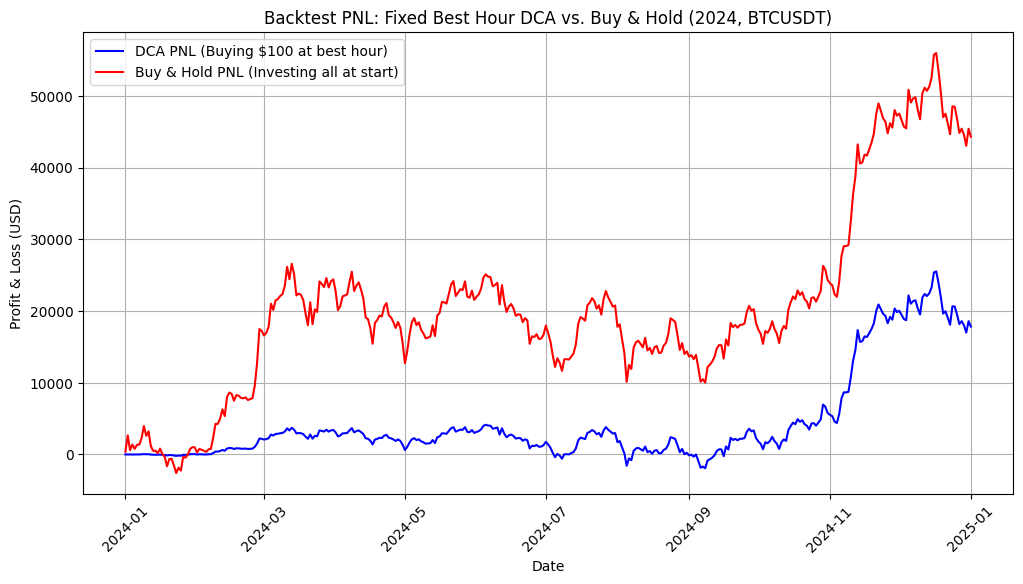

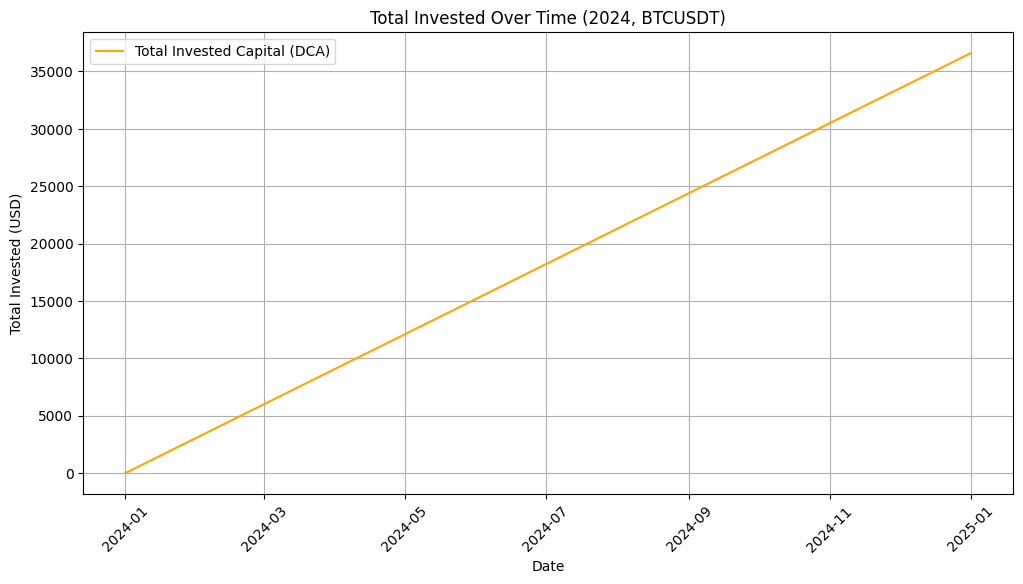

In [4]:
# 1️⃣ Find the Best Buy Hour for the Whole Year
best_hour_summary = full_year_data[full_year_data['action'] == 'Buy']
best_buy_hour = best_hour_summary['hour'].mode()[0]  # Pick the most frequent best hour
print(f"\n🔍 Best Hour for Buying BTC (Whole Year): {best_buy_hour}:00 Vietnam Time")

# 2️⃣ Run Backtest Using Fixed Best Hour
print("\nRunning backtest for buying $100 BTC every day at the best hour...\n")

# Track portfolio
initial_cash = 100  # USD invested per trade
total_days = len(full_year_ohlcv['date'].unique())  # Total days in dataset
portfolio = []  # Stores BTC holdings
cash_invested = 0  # Total invested in USD
btc_holdings = 0  # BTC balance
pnl_over_time = []  # Track PNL over the year
trade_log = []  # Store trade details

for trade_date in full_year_ohlcv['date'].unique():
    # Get next available hour's open price to simulate buy
    trade_time = f"{trade_date} {best_buy_hour:02d}:00"
    next_hour = full_year_ohlcv[full_year_ohlcv['date_hour'] == trade_time]

    if not next_hour.empty:
        buy_price = next_hour.iloc[0]['open']
        btc_bought = initial_cash / buy_price  # How much BTC bought for $100
        btc_holdings += btc_bought
        cash_invested += initial_cash  # Track total invested

        # Log the trade
        trade_log.append({'date': trade_date, 'hour': best_buy_hour, 'buy_price': buy_price, 'btc_bought': btc_bought})
        print(f"✅ Bought BTC on {trade_date} at {best_buy_hour}:00 for ${initial_cash} @ ${buy_price:.2f} -> {btc_bought:.6f} BTC")

    # Find last available close price of the day
    daily_prices = full_year_ohlcv[full_year_ohlcv['date'] == trade_date]['close']
    
    if not daily_prices.empty:
        last_price = daily_prices.iloc[-1]  # Last closing price of the day
        portfolio_value = btc_holdings * last_price
        pnl = portfolio_value - cash_invested  # Unrealized PNL
    else:
        # If no closing price is found, assume last known price
        last_price = last_price if 'last_price' in locals() else 0
        portfolio_value = btc_holdings * last_price
        pnl = portfolio_value - cash_invested

    pnl_over_time.append({'date': trade_date, 'btc_holdings': btc_holdings, 'cash_invested': cash_invested, 'pnl': pnl})

# Convert to DataFrames
pnl_df = pd.DataFrame(pnl_over_time)
trade_log_df = pd.DataFrame(trade_log)

# 3️⃣ Save Trade Log and PNL Results
trade_log_csv = os.path.join(output_dir, f"trade_log_{YEAR}_{SYMBOL}.csv")
pnl_csv = os.path.join(output_dir, f"backtest_pnl_{YEAR}_{SYMBOL}.csv")
trade_log_df.to_csv(trade_log_csv, index=False)
pnl_df.to_csv(pnl_csv, index=False)

print(f"\n📊 Trade log saved to {trade_log_csv}")
print(f"📈 PNL summary saved to {pnl_csv}")

# 4️⃣ Buy & Hold Strategy for Comparison
total_dca_investment = pnl_df['cash_invested'].max()
initial_buy_price = full_year_ohlcv.iloc[0]['open']  # First available open price in 2024
btc_hold = total_dca_investment / initial_buy_price  # BTC bought at start of year
pnl_df['buy_hold_pnl'] = btc_hold * full_year_ohlcv.groupby('date')['close'].last().reindex(pnl_df['date']).values - total_dca_investment

# 5️⃣ Plot DCA vs. Buy & Hold PNL
plt.figure(figsize=(12, 6))
sns.lineplot(data=pnl_df, x='date', y='pnl', label="DCA PNL (Buying $100 at best hour)", color='blue')
sns.lineplot(data=pnl_df, x='date', y='buy_hold_pnl', label="Buy & Hold PNL (Investing all at start)", color='red')

plt.xlabel("Date")
plt.ylabel("Profit & Loss (USD)")
plt.title(f"Backtest PNL: Fixed Best Hour DCA vs. Buy & Hold ({YEAR}, {SYMBOL})")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# 6️⃣ Plot Total Invested Capital Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=pnl_df, x='date', y='cash_invested', label="Total Invested Capital (DCA)", color='orange')

plt.xlabel("Date")
plt.ylabel("Total Invested (USD)")
plt.title(f"Total Invested Over Time ({YEAR}, {SYMBOL})")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()